In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [3]:
sys.path.append("../")
import plotting as my_plot

sys.path.append("./mean_field_elect/")
import proteomics_functions as prot_fun

# Load data

In [7]:
df_master = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')

df_plot = df_master[['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_spf1', 'hccf_spf2', 'pavin_feed', 'pavin_large', 'pavin_small', 'pavin_mab']]
df_plot.columns = ['HCCF Feed', 'HCCF Large agg.', 'HCCF Small agg.', 'HCCF mAb', 'HCCF SPF 1', 'HCCF SPF 2', 'PAVIN Feed', 'PAVIN Large agg.', 'PAVIN Small agg.', 'PAVIN mAb']

# All data

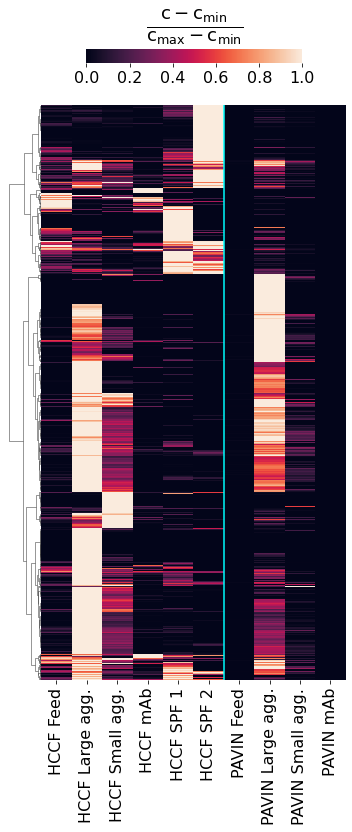

In [10]:
ax = sns.clustermap(df_plot, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(5, 10), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'})

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'$\mathsf{\frac{c - c_{min}}{c_{max} - c_{min}}}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((6, 0), 0, len(df_plot), fill=False, edgecolor='cyan', lw=1.5))

ax.savefig(f'./images/11_swath_clustermap.png', dpi=300, facecolor='white', transparent=False)
ax.savefig(f'./images/11_swath_clustermap.tif', dpi=300, facecolor='white', transparent=False)
ax.savefig(f'./images/11_swath_clustermap.eps', dpi=300)

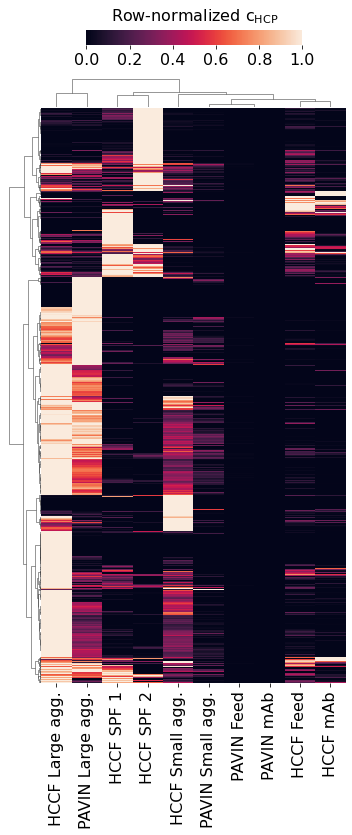

In [11]:
ax = sns.clustermap(df_plot, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(5, 10), yticklabels=False,
                   cbar_pos=(0.25, 1.03, 0.6, 0.02), cbar_kws={'orientation':'horizontal'})

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'Row-normalized $\mathsf{c_{HCP}}$', fontsize=fontsize, pad=10)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

ax.savefig(f'./images/11_swath_clustermap_columns_clustered.png', dpi=300, facecolor='white', transparent=False)

In [12]:
df_in_each = df_master[df_plot.min(axis=1) > 0.0]
print(len(df_in_each))

df_in_all_agg = df_master[(df_master[['hccf_large', 'hccf_small', 'pavin_large', 'pavin_small']].min(axis=1) > 0.0)]
print(len(df_in_all_agg))

for sample in ['hccf_large', 'hccf_small', 'pavin_large', 'pavin_small']:
    df_in_sample = df_master[(df_master[[sample]].min(axis=1) > 0.0)]
    print(sample, len(df_in_sample))

4
883
hccf_large 1980
hccf_small 1635
pavin_large 1883
pavin_small 944


# In each aggregate fraction

In [13]:
df_in_all_agg_plot = df_plot.loc[df_in_all_agg.index]
df_in_all_agg_plot = df_in_all_agg_plot[['HCCF Large agg.', 'HCCF Small agg.', 'PAVIN Large agg.', 'PAVIN Small agg.']]

df_log2 = pd.DataFrame()
df_log10 = pd.DataFrame()
ref = 'HCCF Large agg.'
for col in ['HCCF Large agg.', 'HCCF Small agg.', 'PAVIN Large agg.', 'PAVIN Small agg.']:
    df_log2[col] = np.log2(df_in_all_agg_plot[col]/df_in_all_agg_plot[ref])
    df_log10[col] = np.log10(df_in_all_agg_plot[col]/df_in_all_agg_plot[ref])

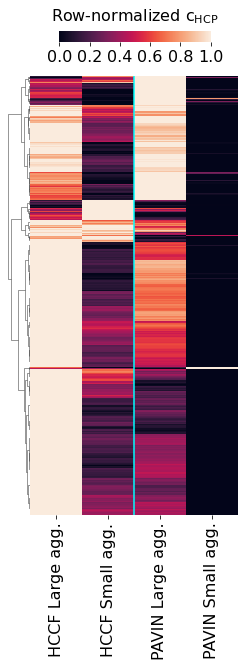

In [14]:
ax = sns.clustermap(df_in_all_agg_plot, method='ward', standard_scale=0, dendrogram_ratio=(0.1, 0.05), figsize=(3.5, 8), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'})

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'Row-normalized $\mathsf{c_{HCP}}$', fontsize=fontsize, pad=10)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((2, 0), 0, len(df_in_all_agg_plot), fill=False, edgecolor='cyan', lw=1.5))

ax.savefig(f'./images/11_swath_exclusive_agg_shared_clustermap_row_normalized.png', dpi=300, facecolor='white', transparent=False)

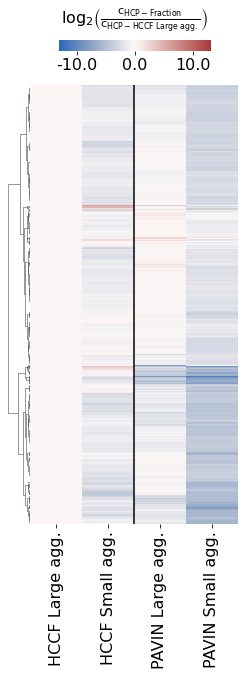

In [15]:
ax = sns.clustermap(df_log2, method='ward', dendrogram_ratio=(0.1, 0.05), figsize=(3.5, 8), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, cmap="vlag", vmin=-13, vmax=13)

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'log$_{2}\left(\frac{\mathsf{c_{HCP - Fraction}}}{\mathsf{c_{HCP - HCCF \; Large \; agg.}}}\right)$', fontsize=fontsize, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((2, 0), 0, len(df_in_all_agg_plot), fill=False, edgecolor='black', lw=1.5))

ax.savefig(f'./images/11_swath_exclusive_agg_shared_clustermap_log2.png', dpi=300, facecolor='white', transparent=False)

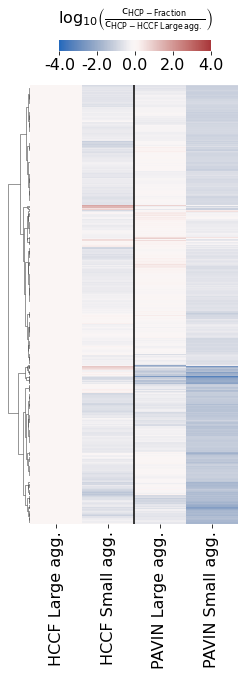

In [16]:
ax = sns.clustermap(df_log10, method='ward', dendrogram_ratio=(0.1, 0.05), figsize=(3.5, 8), yticklabels=False, col_cluster=False,
                   cbar_pos=(0.25, 1.0, 0.6, 0.02), cbar_kws={'orientation':'horizontal'}, cmap="vlag", vmin=-4, vmax=4)

fontsize = 16
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

cbar_text = ax.ax_cbar.set_title(r'log$_{10}\left(\frac{\mathsf{c_{HCP - Fraction}}}{\mathsf{c_{HCP - HCCF \; Large \; agg.}}}\right)$', fontsize=fontsize, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((2, 0), 0, len(df_in_all_agg_plot), fill=False, edgecolor='black', lw=1.5))

ax.savefig(f'./images/11_swath_exclusive_agg_shared_clustermap_log10.png', dpi=300, facecolor='white', transparent=False)